#  🏠 Data Mining Questions  <a id='home'></a>

Process of knowledge discovery from our dataset.

### 🛠️ [Initial Data Pull and Setup](#data_pull)

### ❓ [Data Mining Questions](#questions)
1. [Crime has steadily decreased since 2002, but plateaued in 2016.  Why might crime have plateaued?](#q1)
2. [Crime seems to be disappearing in some areas.  Which neighborhoods have gotten safer, and what might be some of the contributing factors?](#q2)
3. [Crime dropped off significantly in April of 2020.  What were the factors involved?](#q3)


# Part 1: Initial Data Pull and Setup <a id='data_pull'></a>
Links: [🏠](#home) [❓](#questions)

## Part 1a: Imports

In [3]:
# Std lib:
import warnings
import os

# To hide environment variables
from dotenv import load_dotenv

# Data manipulation:
import numpy as np
import pandas as pd
import geopandas
from shapely.geometry import Point, Polygon

# Visualization:
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
%matplotlib inline
style.use('seaborn')

# Display all columns in Jupyter:
from IPython.display import display
pd.options.display.max_columns = None

# Filter Warnings
warnings.filterwarnings('ignore')

## Part 1b: Pull in the Data 

In [4]:
datatypes = {'block': 'object',
             'iucr': 'object',
             'primary_type': 'object',
             'description': 'object',
             'location_description': 'object',
             'arrest': 'bool',
             'domestic': 'bool',
             'beat': 'int64',
             'district': 'float64',
             'ward': 'float64',
             'community_area': 'int64',
             'fbi_code': 'object',
             'x_coordinate': 'float64',
             'y_coordinate': 'float64',
             'year': 'int64',
             'latitude': 'float64',
             'longitude': 'float64',
             'location': 'object',
             'month': 'uint8',
             'hour': 'uint8',
             'dayofweek': 'uint8',
             'weekend': 'bool',
             'CF': 'float64',
             'CF3': 'float64',
             'PI': 'float64',
             'EUH': 'float64',
             'CH': 'float64',
             'SOI': 'float64',
             'crime_code_category': 'category',
             'index_crime': 'bool',
             'violent_crime': 'bool',
             'property_crime': 'bool',
             'crime_against_persons': 'bool',
             'crime_against_property': 'bool',
             'crime_against_society': 'bool'}

In [5]:
load_dotenv()
path_to_data = os.environ.get('CLEAN_DATA')
df = pd.read_csv(path_to_data, dtype=datatypes)

<a id='home'></a>

### Question 1: Crime has steadily decreased since 2002, but plateaued in 2016. Why might crime have plateaued?

In [14]:
first_year = 2002
last_year = 2020
q1_df = df[df.year.isin(list(range(2002, 2020)))]

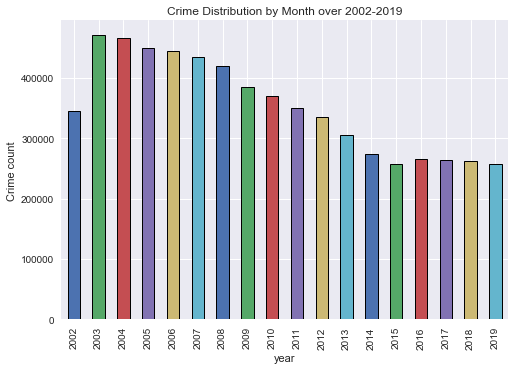

In [16]:
histoy = q1_df.groupby('year').size().plot.bar(edgecolor='black', linewidth=1, color=sns.color_palette())
histoy.set_title('Crime Distribution by Month over 2002-2019')
histoy.set_ylabel('Crime count');

One way to gain insight into this question is to see if crime uniformly plateaued (all individual types of crime followed the same pattern as total crime) or if we had a specific spike in one type of crime and reduction in another.

Let's look at the trends on a few individual crimes:

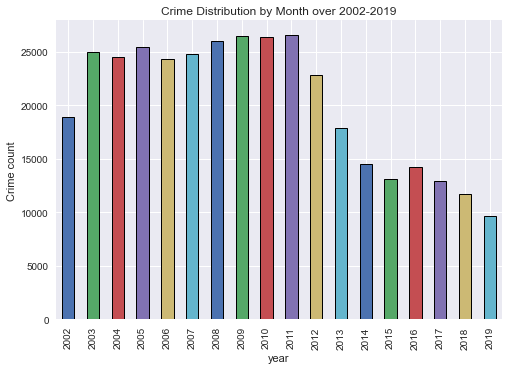

In [26]:
type_of_crime = 'BURGLARY'

histoy = q1_df[q1_df.primary_type == type_of_crime].groupby('year').size().plot.bar(edgecolor='black', linewidth=1, color=sns.color_palette())
histoy.set_title('Crime Distribution by Month over 2002-2019')
histoy.set_ylabel('Crime count');

In [59]:
top_9_crimes = q1_df.groupby('primary_type').size().sort_values(ascending=False)[:10].index.to_list()
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(20, 10))

# for idx, crime in enumerate(top_9_crimes):
#     q1_df[q1_df.primary_type == type_of_crime].groupby('year').size().plot.bar(edgecolor='black', linewidth=1, color=sns.color_palette(), ax=ax1)

# plt.subplots_adjust(wspace=0.50, hspace=0.5)